In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy estimation (TRAINING)

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

Part of this notebook was performed by `protopipe.scripts.model_diagnostics` which will be discontinued.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

based on previous work by J. Lefacheur.

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding information from training data used for the training of the energy model.
Additional information is provided by protopipe.scripts.model_diagnostics, which is being gradually migrated here and it will be eventually discontinued.

**NOTES:**

- these benchmarks will be cross-validated and migrated in cta-benchmarks/ctaplot
- Let's try to follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding those benchmarks or proposing new ones. 

**Requirements:**

To run this notebook you will need a set of trained data produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ (1 full DL1 file + 1 DL2 file with only shower geometry information).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* finish to merge model diagnostics output
* add remaining benchmarks from CTA-MARS comparison
* same for EventDisplay

## Table of contents
- [Charge profile](#Charge-profile)

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
cmap = dict()
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
#cmap = {'black': 0, 'red': 1, 'blue': 2, 'green': 3}
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
from pathlib import Path
import numpy as np
import pandas as pd

## Functions

In [3]:
def plot_profile(ax, data, xcol, ycol, n_xbin, x_range, logx=False, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    fill = kwargs.get('fill', False)
    alpha = kwargs.get('alpha', 1)
    xlabel = kwargs.get('xlabel', '')
    ylabel = kwargs.get('ylabel', '')
    xlim = kwargs.get('xlim', None)
    ms = kwargs.get('ms', 8)
    
    if logx is False:
        bin_edges = np.linspace(x_range[0], x_range[-1], n_xbin, True)
        bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
    else:
        bin_edges = np.logspace(np.log10(x_range[0]), np.log10(x_range[-1]), n_xbin, True)
        bin_center = np.sqrt(bin_edges[1:] * bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
    
    y = []
    yerr = []
    for idx in range(len(bin_center)):
        counts = data[ (data[xcol] > bin_edges[idx]) & (data[xcol] <= bin_edges[idx+1]) ][ycol]
        y.append(counts.mean())
        yerr.append(counts.std() / np.sqrt(len(counts)))
        
    ax.errorbar(x=bin_center, y=y, xerr=bin_width / 2., yerr=yerr, label=label, fmt='o', color=color, ms=ms)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx is True:
        ax.set_xscale('log')
    ax.legend(loc='upper right', framealpha=1, fontsize='medium')
    #ax.grid(which='both')
    return ax

## Load

In [4]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)

In [5]:
# Setup for data loading

parentDir = "" # Full path location of 'shared_folder'
analysisName = ""

# Load data
mode = "tail"
indir = os.path.join(parentDir, "shared_folder/analyses", analysisName, "data", "TRAINING/for_energy_estimation")
infile = 'TRAINING_energy_{}_gamma_merged.h5'.format(mode)

data_image = pd.read_hdf(os.path.join(indir,infile), key='LSTCam')
print('#Images={}'.format(len(data_image)))
data_image['log10_hillas_intensity'] = np.log10(data_image['hillas_intensity'])

#Images=2157984


## Benchmarks

### Charge profile
[back to top](#Table-of-contents)

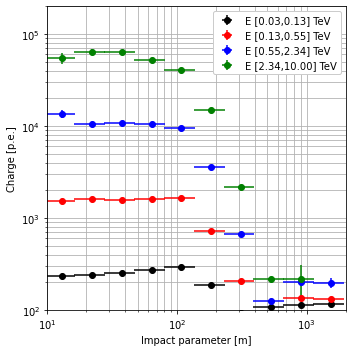

In [6]:
tel_ids = [1, 2, 3, 4] # WARNING! These are only the LSTs!
n_feature = len(tel_ids)
nrows = int(n_feature / 2) if n_feature % 2 == 0 else int((n_feature + 1) / 2)

emin = 0.03
emax = 10
nbin = 4
energy_range = np.logspace(np.log10(emin), np.log10(emax), nbin + 1, True)

#plt.figure(figsize=(10,10))
#fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 10))
#axes = axes.flatten()

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
for jdx in range(0, len(energy_range) - 1):
        
    data_sel = data_image[data_image['N_LST'] >= 2]
    data_sel = data_sel[(data_sel['true_energy'] >= energy_range[jdx]) & 
                        (data_sel['true_energy'] < energy_range[jdx + 1])]
        
    xbins = 10 + 1
    xrange = [10, 2000]
    opt = {'xlabel': 'Impact parameter [m]', 'ylabel': 'Charge [p.e.]', 'color': cmap[jdx],
           'label': 'E [{:.2f},{:.2f}] TeV'.format(energy_range[jdx], energy_range[jdx+1]),
           'ms': 6}
    plot_profile(ax, data=data_sel,
                 xcol='impact_dist', ycol='hillas_intensity',
                 n_xbin=xbins, x_range=xrange, logx=True, **opt)
    #ax.grid(which='both')
    ax.set_yscale('log')
    ax.set_yscale('log')
    ax.set_ylim([100, 2. * 100000.])
    ax.set_xlim([10, 2000])

ax.grid(which='both')
plt.tight_layout()

fig.savefig(f"./plots/training_charge_profile_protopipe_{analysisName}.png")